# In this notebook, we use some simple models to see how the use of both EEG and EOG affect the results of the sleep classification

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import os
import glob
import numpy as np
import gzip as gz
import pickle
from tqdm import tqdm
from transformers import AutoModel, AutoConfig
from torch.utils.data import TensorDataset, DataLoader, random_split

# 1) Preparation of the pickle file, we need to compute it for every different set of data we want to study

For the moment let's only focus on the Sleep Cassette :
The 153 `SC*` files (SC = Sleep Cassette) were obtained in a 1987-1991 study of age effects on sleep in healthy Caucasians aged 25-101, without any sleep-related medication. Two PSGs of about 20 hours each were recorded during two subsequent day-night periods at the subjects homes. Subjects continued their normal activities but wore a modified Walkman-like cassette-tape.
Files are named in the form `SC4ssNEO-PSG.edf` where `ss` is the subject number, and `N` is the night. 

In [4]:
data_path = '/Users/martinblot/Desktop/sleep-edf-prepared/5-cassette'  ## path towards the 5-cassette file
fp = gz.open(data_path+'/SC4001E0.npz.gz','rb')
data_test = np.load(fp,allow_pickle=True)

x is separed into 4 different experiments : EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, EMG submental

We can then prepare the data for training and validation

In [5]:
fnames = glob.glob(os.path.join(data_path, "*npz.gz"))

In [6]:
devpart = 10
xtrain , xvalid = None , None
ytrain , yvalid = None , None
measurement=data_test['ch_label'][0:3]

for fn in tqdm(fnames):
    fp = gz.open(fn,'rb')
    data = np.load(fp,allow_pickle=False) # for now, don't care about headers
    x = data['x'][:,:,0:3] # 2 EEG and EOG
    y = data['y'] # Take the labels
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    devlim = x.shape[0]//devpart
    devpart = 10
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    devlim = x.shape[0]//devpart
    if xtrain is None:
        xtrain = np.zeros((1,x.shape[1],3))    ##np.zeros((1,x.shape[1],2)) if we include EOG  
        xvalid = np.zeros((1,x.shape[1],3))
        ytrain , yvalid = np.zeros(1) , np.zeros(1)
    xvalid = np.concatenate((xvalid,x[idx[:devlim]]), axis=0)
    yvalid = np.concatenate((yvalid,y[idx[:devlim]]), axis=0)
    xtrain = np.concatenate((xtrain,x[idx[devlim:]]), axis=0)
    ytrain = np.concatenate((ytrain,y[idx[devlim:]]), axis=0)
    del x,y

100%|██████████| 153/153 [03:27<00:00,  1.36s/it]


In [ ]:
print(xtrain.shape,ytrain.shape,xvalid.shape,yvalid.shape)

(175996, 600, 3) (175996,) (19485, 600, 3) (19485,)


In [12]:
# clean the first dummy example
xtrain , xvalid = xtrain[1:] , xvalid[1:]
ytrain , yvalid = ytrain[1:] , yvalid[1:]
print(xtrain.shape, xvalid.shape)

torch.Size([175994, 600, 3]) torch.Size([19483, 600, 3])


In [13]:
# In Torch version
xtrain, xvalid = th.FloatTensor(xtrain), th.FloatTensor(xvalid)
ytrain, yvalid = th.IntTensor(ytrain), th.IntTensor(yvalid)

Store data as a pickle file : to do only ONCE

In [16]:
outf="/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck"
fp = open(outf,"wb")
pickle.dump((xtrain , xvalid , ytrain , yvalid), fp)

# 2) Open the pickle file : reuse this in a code to train a model

In [17]:
filepath = '/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck'
xtrain,xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
print(xtrain.shape)

torch.Size([175994, 600, 3])


Plot the data and visualize to what stage of sleep it corresponds

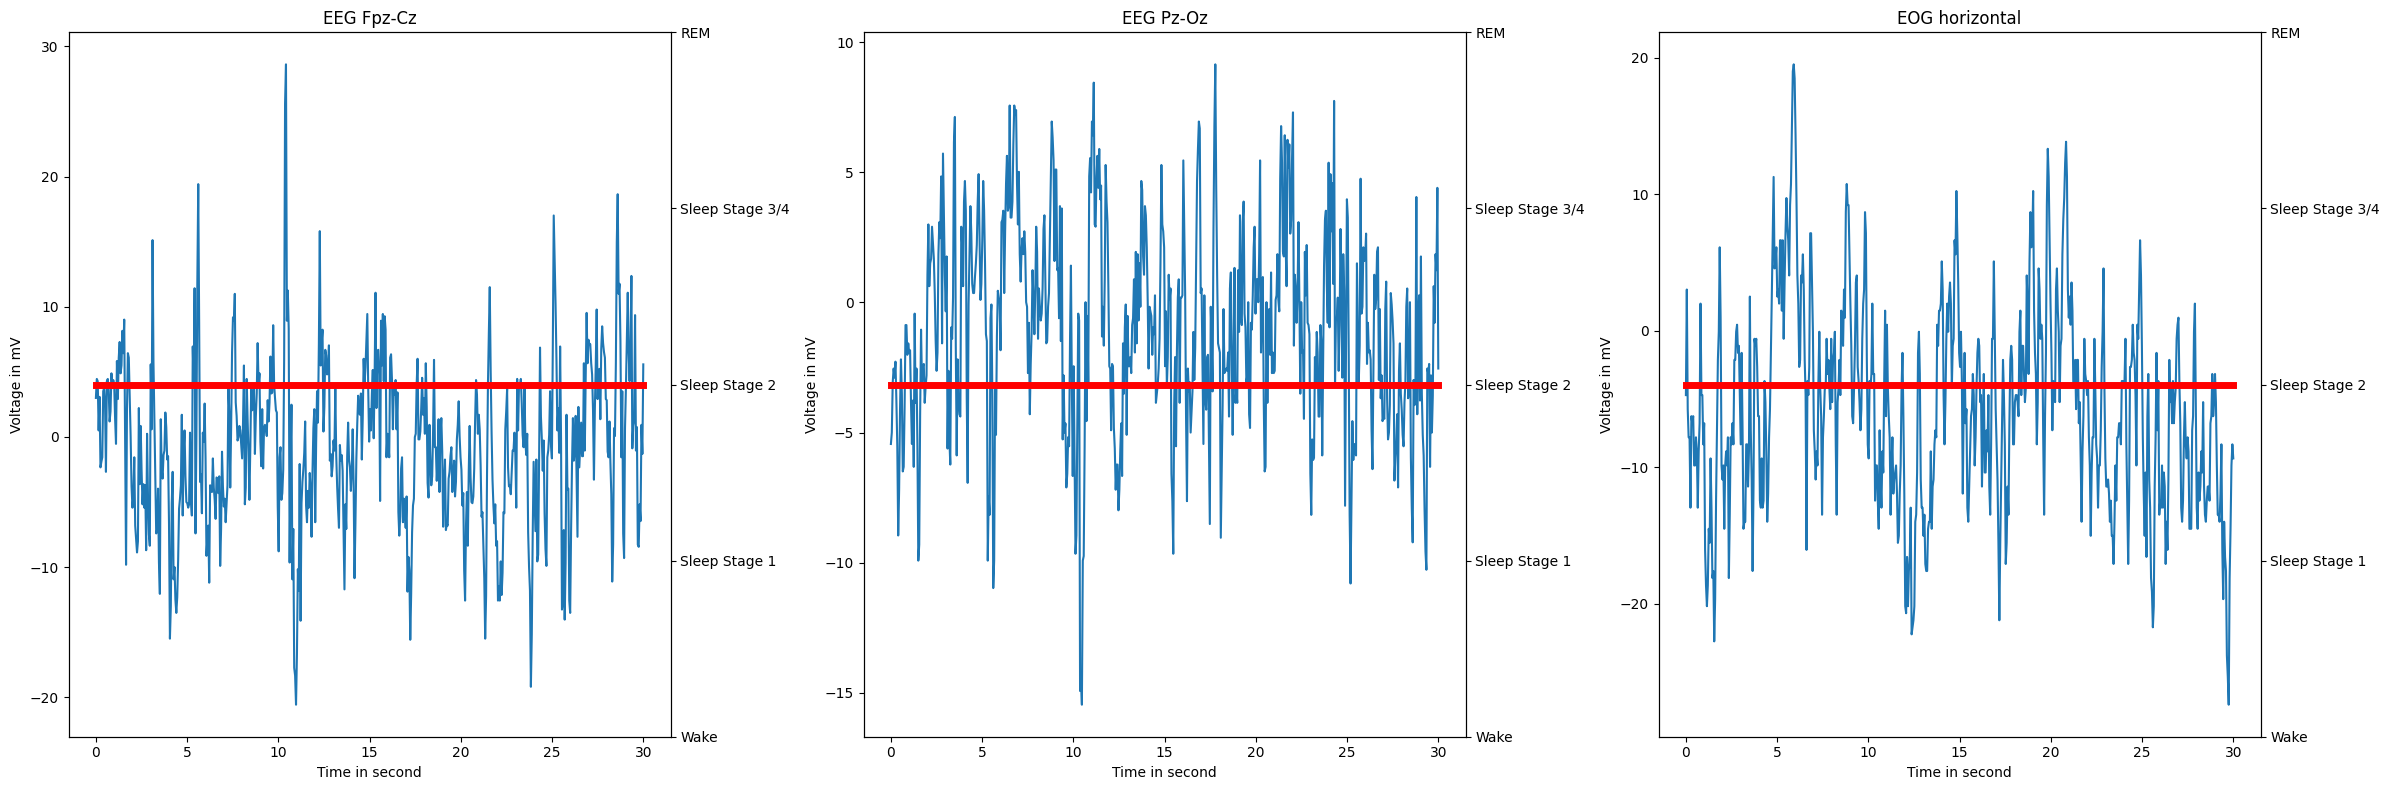

In [29]:
numero_analyse=300
time=np.linspace(0,30,xtrain.shape[1])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

ax1.plot(time, xtrain[numero_analyse,:,0])
ax1.set_xlabel('Time in second')
ax1.set_ylabel('Voltage in mV')
ax1.set_title(measurement[0])
ax1_2 = ax1.twinx()
ax1_2.plot(time, ytrain[numero_analyse]*np.ones(time.shape), color='red', linewidth=5)
ax1_2.set_yticks([0, 1, 2, 3, 4])
ax1_2.set_yticklabels(['Wake', 'Sleep Stage 1', 'Sleep Stage 2', 'Sleep Stage 3/4', 'REM'], fontsize=10)

ax2.plot(time, xtrain[numero_analyse,:,1])
ax2.set_xlabel('Time in second')
ax2.set_ylabel('Voltage in mV')
ax2.set_title(measurement[1])
ax2_2 = ax2.twinx()
ax2_2.plot(time, ytrain[numero_analyse]*np.ones(time.shape), color='red', linewidth=5)
ax2_2.set_yticks([0, 1, 2, 3, 4])
ax2_2.set_yticklabels(['Wake', 'Sleep Stage 1', 'Sleep Stage 2', 'Sleep Stage 3/4', 'REM'], fontsize=10)

ax3.plot(time, xtrain[numero_analyse,:,2])
ax3.set_xlabel('Time in second')
ax3.set_ylabel('Voltage in mV')
ax3.set_title(measurement[2])
ax3_2 = ax3.twinx()
ax3_2.plot(time, ytrain[numero_analyse]*np.ones(time.shape), color='red', linewidth=5)
ax3_2.set_yticks([0, 1, 2, 3, 4])
ax3_2.set_yticklabels(['Wake', 'Sleep Stage 1', 'Sleep Stage 2', 'Sleep Stage 3/4', 'REM'], fontsize=10)
plt.tight_layout()
plt.show()

Now we have understand everything about the data we can compute some models to train !

# 3) Training a basic model

In [ ]:
class CNN(nn.Module):
    def __init__(self,channels=1, dropout_prob=0.3):   ## channels=1 si uniquement EOG, channels=3 si EOG et les 2 EEG
        super(CNN, self).__init__()
        self.dropout_prob = dropout_prob
        self.channels = channels
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels=self.channels, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Dropout(p=self.dropout_prob),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Dropout(p=self.dropout_prob),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Dropout(p=self.dropout_prob)
        )
        self.fc = nn.Linear(64*74, 5)
    
    def forward(self, x):
        if self.channels==1:
              x = x.unsqueeze(1)   # Ajouter une dimension de canal si on ne considère que l'EOG 
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = nn.functional.softmax(x, dim=1)
        
        return x
        

In [ ]:
model=CNN(channels=3,dropout_prob=0.3)

In [ ]:
xtrain_tensor,ytrain_tensor=th.tensor(xtrain),th.tensor(ytrain)
xvalid_tensor,yvalid_tensor=th.tensor(xvalid),th.tensor(yvalid)

dataset_t = TensorDataset(xtrain_tensor, ytrain_tensor)
train_loader = DataLoader(dataset_t, batch_size= 100, shuffle=True)
dataset_v = TensorDataset(xvalid_tensor, yvalid_tensor)
valid_loader = DataLoader(dataset_v, batch_size= 100, shuffle=True)

/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_35096/2274306407.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtrain_tensor,ytrain_tensor=th.tensor(xtrain),th.tensor(ytrain)


/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_35096/2274306407.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xvalid_tensor,yvalid_tensor=th.tensor(xvalid),th.tensor(yvalid)


## Training loop

In [2]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 15
for epoch in range(num_epochs):
    total_train_correct = 0.0
    total_train_samples = 0.0
    train_loss = 0.0
    total_val_correct = 0.0
    total_val_samples = 0.0
    val_loss = 0.0
    model.train() 
    for inputs, labels in train_loader:
        inputs=inputs.transpose(2,1)
        labels=labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = th.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    

    model.eval() 
    with th.no_grad():
        for inputs_val, labels_val in valid_loader:
            inputs_val=inputs_val.transpose(2,1)
            outputs_val = model(inputs_val)
            val_loss += criterion(outputs_val, labels_val.to(int)).item()
            
            _, predicted_val = th.max(outputs_val, 1)
            total_val_correct += (predicted_val == labels_val).sum().item()
            total_val_samples += labels_val.size(0)

    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = total_val_correct / total_val_samples
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution de la perte pendant l\'entraînement')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolution de la précision pendant l\'entraînement')
plt.legend()
plt.show()

NameError: name 'model' is not defined